In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import sys
import os
sys.path.append("../dataprocess")
import dataprocess as dp

##### Function definitions

In [2]:
def inverse_transf(X_train: np.ndarray, X_test: np.ndarray, r_max: int, r_step: int):
    """Perform inverse transform and map from the embedded s
        pace to the original space

    Args:
        X_train (np.ndarray): train data matrix
        X_test (np.ndarray): test data matrix
        r_max (int): max number of modes to keep
        r_step (int): mode number increment for calculating the reconstruction error

    Returns:
        X_reconstructed (np.ndarray): reconstructed data with r_max modes
        err_rec (np.ndarray): vector containing the reconstruction error for 1 to r_max modes
    """
    err_rec = np.zeros(len(range(1, r_max + 1, r_step)))
    i = 0

    for r in range(1, r_max + 1, r_step):
        pca = PCA(n_components=r)
        pca.fit(X_train)
        X_pca_test = pca.transform(X_test)
        X_reconstructed = pca.inverse_transform(X_pca_test)
        err_rec[i] = np.linalg.norm(X_test - X_reconstructed) / np.linalg.norm(X_test)
        i += 1
    return X_reconstructed, err_rec

#### Parameters

In [3]:
# Mesh
nx = 227  # X-direction nodes
ny = 120  # Y-direction nodes
# Domain:
Lx = 17.665369  # Lx (Size of the box in x-direction)
Ly = 9.0  # Ly (Size of the box in y-direction)
# Cylinder coordinates:
X_0 = 2.66537  # X coordinate of the center
Y_0 = 4.5  # Y coordinate of the center
r = 0.5  # Cylinder radius

mesh = dp.Mesh(nx, ny, Lx, Ly, X_0, Y_0, r)

# Data path
re = 50
input_dir = "../data/"
input_filename = f'modVcropRe{re}.csv'
# Max number of components and step for postprocess
r_max = 12
r_step = 1

#### Data pre-processing

In [ ]:
''' Read velocity data
  X - velocity module
 rows of X correspond to velocity components at spatial locations
 columns of X correspond to timesteps
     t_1 t_2.  .  t_n
 X = [u  u  .  .  .]  (x_1,y_1)
     [v  v  .  .  .]  (x_1,y_1)
     [w  w  .  .  .]  (x_1,y_1)
     [u  u  .  .  .]  (x_2,y_2)
     [v  v  .  .  .]  (x_2,y_2)
     [w  w  .  .  .]  (x_2,y_2)
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
'''

input_filename = f"modVcropRe{re}.csv"
X = dp.read_X_csv(input_dir + input_filename)
X_train, X_test = train_test_split(
    X.T,
    test_size=0.5,
    shuffle=False,
)
X_train = X_train.T
X_test = X_test.T



n, m = X_train.shape

print("Data matrix X is n by m:", n, "x", m, flush=True)


# Erase cylinder from snapshot
X_train_filt = dp.erase_cyl(X_train, mesh)
X_test_filt = dp.erase_cyl(X_test, mesh)

spatial_red = True
# Standardize data. Sklearn uses differente notation from ours!!
std_scaler = StandardScaler()
if spatial_red:
    #computes temporal mean (row-wise mean)
    X_train_filt = std_scaler.fit_transform(X_train_filt.T).T
    X_test_filt = std_scaler.fit_transform(X_test_filt.T).T
else:
    #computes spatial mean (column-wise mean)
    X_train_filt = std_scaler.fit_transform(X_train_filt)
    X_test_filt = std_scaler.fit_transform(X_test_filt)
print("Snapshot points without cylinder", X_train_filt.shape)

#### Perform PCA

In [7]:
'''sklearn adopts different convention for the data matrix,
that is, it will reduce the number of columns by default,
leading to temporal reduction.'''
start = time.time()
pca = PCA(n_components=r_max)
X_pca = pca.fit_transform(X_train_filt)
end = time.time()
print("Time elapsed for PCA:", end - start, " s")
print("X_pca shape", X_pca.shape)

Time elapsed for PCA: 0.4208712577819824  s
X_pca shape (27104, 12)


### Post-process

#### Save and plot PCA modes

In [8]:
# save modes in csv and png files
save_flag = True
if save_flag:
    out_dir = "modes/"
    modesToSave = r_max
    if modesToSave > X_pca.shape[1]:
        print("Number of modes is greater than the number of components in X_modes")
    dp.save_modes(X_pca, out_dir, modesToSave, mesh)

##### Data reconstruction for different number of components

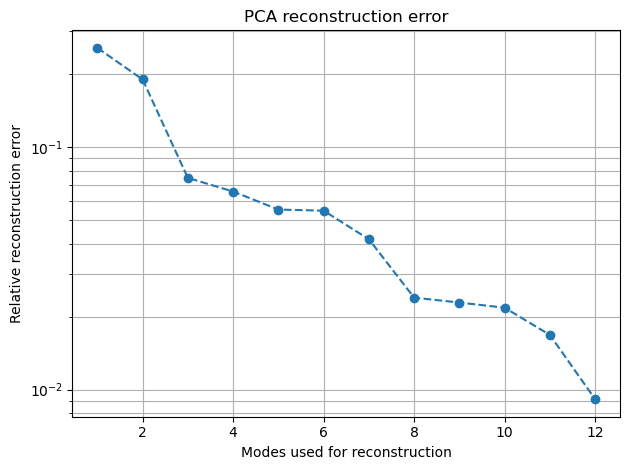

In [10]:
X_reconstructed, err_rec = inverse_transf(X_train_filt, X_test_filt, r_max, r_step)
# Save reconstruction errors for further post-processing
np.savetxt("error_rec.csv", err_rec, delimiter=",")
dp.plot_save_reconst(err_rec, r_max, r_step, 'PCA')